# Dosimetría fotográfica
---------
El objeto de este cuaderno es procesar películas radiocrómicas EBT3 leídas con un escáner de sobremesa para obtener mapas de dosis absorbida analizables mediante Portal Dosimetry (Varian). 

Las entradas del cuaderno son el plano de dosis exportado desde el planificador en formato `dcm` (DICOM RT) y la imagen digitalizada en fomato TIFF (color 48 bits). Para funcionar el cuaderno también necesita un archivo de configuración con datos sobre el escáner, las condiciones de calibración, de digitalización y de corrección tanto del ruido como del efecto lateral. 

Las salidas del cuaderno son el plano de dosis exportado desde el planificador convertido a formato `dxf` y el plano de dosis medido con la película también en `dxf`. El formato `dxf` es un tipo de archivo definido por Varian para el intercambio de datos. Se trata de archivos de texto del tipo valores separados por comas (`csv`) y un encabezado con metainformación de la medida. Ambos archivos se pueden importar en Portal Dosimetry para su análisis y comparación.

El procesado de las películas sigue un esquema de digitalización única (SSP, *single scan protocol*) leyéndose la película en la misma digitalización en la que se calibra el escáner. Si la película de calibración se ha irradido en la misma sesión que la película a medir, el procedimiento es independiente del tiempo de evolución de la película, evitando tener que esperar el tiempo de estabilización. El procesado utiliza un análisis multicanal mediante promedios no locales. La calibración se realiza mediante un modelo sensitométrico de crecimiento con la dosis de dos fases del polímero, que es estable en el tiempo para un modelo de escáner y película dados. Las condiciones particulares resultado de la conservación del lote de fabricación de la película, el fondo y el estado del escáner se establecen durante la digitalización. El algoritmo también corrige por el efecto lateral. Este procedimiento permite obtener dosis que es directamente trazable a patrones de calibración.

## Procedimiento

| **Acción** | **Función** |
|----------|---------|
|Subir el plano de dosis calculado (formato `DICOM`) y convertir a formato `dxf`       | `exportarPlanoDosisPlanificador()`|
|Importar imagen digitalizada                                                          | `subirImagenDigitalizada()`       |
|Restauración de artefactos lineales en la  digitalización (*opcional*)                | `corregirScanner()`               |
|Etiquetar en la imagen digitalizada las regiones relevantes para aplicar el SSP       | `segmentarImagen()`               |
|Determinar la dosis en la película                                                    | `procesarPelicula()`              |
|Reorientar el plano de dosis medido                                                   | `reorientarYExportarPlanoDosisPelicula()`  |
|Exportar la distribución espacial de dosis medida en formato `dxf`                    | `reorientarYExportarPlanoDosisPelicula()`  |

Para aplicar este procedimiento seguir en orden secuencial las celdas del cuaderno.

## Código
-----------------

### Configuración del cuaderno

Importación de funciones 

In [1]:
%matplotlib widget
from ipyfilmqa import leerConfiguracion, exportarPlanoDosisPlanificador
from ipyfilmqa import representarPlanoDosisPlanificador, representarOrientacionesPlanoDosisPelicula
from ipyfilmqa import subirImagenDigitalizada, corregirScanner, segmentarImagen, procesarPelicula
from ipyfilmqa import reorientarYExportarPlanoDosisPelicula

Leer la configuración del módulo de dosimetría fotográfica

In [2]:
leerConfiguracion()

### Planificador

Convertir el plano de dosis calculado en el planificador de formato DICOM a `dxf`

In [3]:
exportarPlanoDosisPlanificador()

FileUpload(value={}, accept='.dcm, .DCM', description='Upload')

Output()

### Película

Subir al servidor la imagen digitalizada que contiene la película irradiada, la película de calibración y la película sin irradiar

In [4]:
subirImagenDigitalizada()

FileUpload(value={}, accept='.tif, .tiff', description='Upload')

Output()

Corregir artefactos lineales en la digitalización *(opcional)*

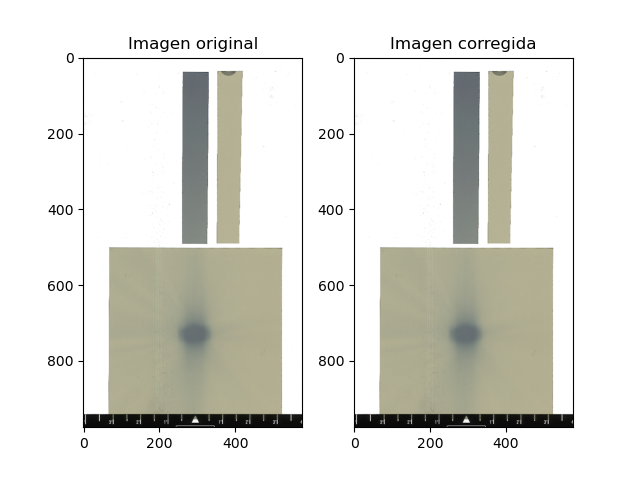

In [5]:
corregirScanner()

Etiquetar en la imagen las regiones con la dosis medida, el recorte de calibración, el fondo y la indicación del centro del digitalizador en la dirección de la lámpara. Una vez etiquetada no olvidar pulsar el botón **Submit**

In [5]:
segmentarImagen()

BBoxWidget(classes=['Film', 'Calibration', 'Background', 'Center'], colors=['#1f77b4', '#ff7f0e', '#2ca02c', '…

Convertir en dosis la lectura de la película

In [6]:
%%capture --no-stdout --no-display

procesarPelicula()

Determinación de las coordenadas para la corrección lateral...
Determinación del fondo...
Calibración de la digitalización...
Dose preprocessing...
Dose calculation:


  0%|          | 0/453 [00:00<?, ?it/s]

La irradiación de la película puede realizarse orientándola de cualquier modo, pero la digitalización siempre se tiene que hacer respetando la orientación en la fue calibrada. En nuestro protocolo hemos decidido que sea en orientación *portrait*. De acuerdo a nuestros protocolos de corte siempre se marca la esquina superior derecha de cada recorte con un guión paralelo a la dirección estrecha de la película sin cortar. La lectura de la película se tiene que hacer colocándola en la bandeja del escáner con el guión paralelo a la lámpara del escáner.

La siguiente función permite reorientar la imagen en dosis para hacerla coincidir con el plano de dosis calculado en el planificador y después exporta el plano de dosis calculado en formato `dxf`.

Plano de dosis calculado:


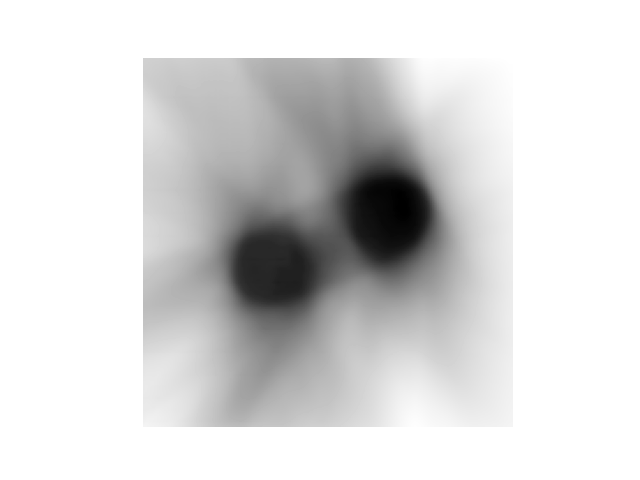

Seleccionar la orientación correcta del plano de dosis medido:


In [7]:
reorientarYExportarPlanoDosisPelicula()

## Documentación
---------

### Cálculo del plano de dosis en el planificador
En Eclipse desde el plan que se quiere medir, seleccionar Create Verification Plan y seguir el procedimiento del planificador.

La selección de planos de dosis en Eclipse requiere que el plano contenga el isocentro de un campo como referencia. Si se quiere seleccionar un plano que no contenga el isocentro del plan de tratamiento es necesario añadir un campo con peso 0 con su isocentro situado sobre el plano de interés y centrado en el plano de dosis.

<img src="Images/PlaneSelection.jpg"/>

En la imagen anterior a un plan HyperArc se le han añadido dos campos para poder exportar planos sagitales desplazados 1 cm respecto al cetnro del maniquí. Por tanto esos campos están centrados en x = 0 , y = +1, z = 0, y en  x = 0 , y = -1, z = 0

Calcular la distribución de dosis y seleccionar la ventana que contenga el plano que se quiere exportar. Registrar si se trata de un plano axial, sagital o coronal. En la imagen anterior puede verse que la ventana iluminada es la que corresponde a los planos sagitales.

Con el botón derecho sobre el icono Dose ir a la opción Export Dose Plan. 

<img src="Images/ExportDosePlane.jpg"/>

Seleccionar dosis absoluta y el campo que tiene su isocentro situado sobre el plano que se exporta. No activar la opción del marcado de la película. Indicar las dimensiones del plano que se exporta, normalmente 16 cm por 16 cm. Una resolución espacial razonable es 1 pixel por milímetro.

<img src="Images/ExportDosePlaneOptions.jpg"/>

En la ventana de configuración de la exportación se puede seleccionar la carpeta en la que se exporta el plano de dosis, que debería ser la carpeta del paciente en Radiofisica\Medidas Pacientes\IMRT

<img src="Images/ExportDosePlaneConfigureOptions.jpg"/>

### Preparación de la película para la medida
El tamaño de las películas con las que se mide está limitado por el tamaño del maniquí sobre el que se ha calculado el plan de verificación. Lo que sí es posible es irradiar películas de un tamaño inferior. 

Cortar la película con las dimensiones del plan calculado, normalmente un cuadrado de 16 cm por 16 cm.

<img src="Images/cortetransversal.jpg"/>

<img src="Images/recortemedida.jpg"/>

Antes de cortar la película marcar las esquinas superiores de las áreas a cortar y restantes con un guión que sea paralelo a la dimensión estrecha de la película original. Ver la siguiente ilustración 

<img src="Images/marcasrecortes.png"/>

### Preparación de la película de calibración
El tamaño de la tira de calibración tiene que ser de unos centímetros de ancho por 16 cm de largo, con su dimensión longitudinal en la dirección *portrait*.

La forma óptima de prepararla es ir cortando tiras a partir de un recorte sin irradiar de una película de medida. No olvidar marcar la orientación de los recortes.

### Irradiación

#### Control de calidad del plan de un paciente
Colocar la película en el interior del maniquí de calidad en la localización del plano cálculado. La orientación de la película en este momento no es relevante.

Situar el maniquí en el acelerador, alinear, cargar el plan e irradiar.

#### Calibración
Colocar la tira de calibración en el plano central del maniquí con su dimensión longitudinal según el eje vertical del acelerador. Tapar el maniquí. 

En un acelerador Artiste alinear el maniquí con los láseres y subir la mesa hasta una distancia fuente superficie de 75 cm. Con energía 6X programar un campo de 10x10, Gantry 0º y Colimador 0º. Irradiar 346.5 unidades monitor.

### Digitgalización

Colocar las muestras de película en la bandeja del escáner de acuerdo a la siguiente distribución

<img src="Images/disposicionEscaner.jpg"/>

Para poder introducir la corrección por efecto lateral es necesario contar con una referencia de la posición de las películas en el escáner. En este imagen se obtiene mediante la regla móvil inferior.

Las condiciones de digitalización son en modo transmisión en color 48 bits con una resolución de 72 puntos por pulgada.

Realizar un prescan y fijar un ROI que incluya completamente todas las películas y al menos la marca de centraje de la regla inferior.

### Procesado

#### Planificador

Para los datos del planificador solo es necesario convertir el plano de dosis calculado en el planificador de formato `DICOM` a `dxf`. Emplear la función `exportarPlanoDosisPlanificador()` y pulsar sobre el botón `Upload`. Ir a la carpeta en la que se haya exportado el plano de dosis en formato `DICOM` y seleccionarlo. La función crea una copia del archivo localmente en el servidor y lo convierte a formato `dxf` guardándolo en la carpeta del paciente. Por defecto utiliza la información DICOM para identificar el número de historia del paciente y su correspondiente carpeta.

#### Película

La conversión de la señal digital de la película a dosis y su exportación en formato `dxf` se realiza en cuatro pasos, el primero de ellos opcional.

##### Correción (*opcional*) de artefactos lineales en la digitalización

Las líneas verticales que aparecen ocasionalmente al digitalizar se deben a motas de polvo que alteran la calibración inicial del escáner. Pueden ser atenuadas *parcialmente* mediante un factor constante que se aplica en la posición en la que ocurren. 

Para corregirlas utilizar la función `corregirScanner()`. La función muestra unos cuadros de texto para la introducción de datos, unos botones y dos imágenes: original y corregida.

<img src="Images/corregirScanner.jpg" />

En el cuadro Pixels se debe introducir la lista de pixels anómalos. Se pueden identificar con la ayuda de la posición del cursor que se muestra en la parte inferior de la figura pasando el ratón por la imagen .

En el cuadro Factores se deben introducir los correspondientes factores de corrección. Cuanto más brillante es el artefacto más pequeño tiene que ser el factor de corrección. Valores razonables se encuentran entre 0.9 y 1.

El botón `Corregir` aplica la corrección y la muestra en la figura de la derecha. Si la corrección no es adecuada se pueden modificar los pixels o los factores y volver a corregir.

El botón `Actualizar` sustituye la imagen subida al servidor con la imagen corregida.

El botón `Restaurar` devuelve la imagen a su situación inicial. 

##### Segmentación 

Para procesar la película con una calibración actualizada y corregida espacialmente es necesario identificar en la imagen digitalizada una serie de regiones que contienen la película, la tira de calibración, una tira de control del fondo y una marca de centraje.

Para segmentar la imagen emplear la función `segmentarImagen()`

<img src='Images/segmentarImagen.jpg'/>

Seleccionar en la parte inferior cada una de las clases a segmentar y arrastrando con el ratón sobre la imagen ajustar los bordes de la región correspondiente. En la región de calibración son importantes los bordes superior e inferior. En la región del fondo basta con tomar una zona suficientemente grande. En la región del centro es suficiente cualquier rectángulo que tenga su punto central alineado aproximadamente con la marca trinangular de la regleta.

Una vez que los bordes son correctos hay que pulsar el botón `Submit`. Al hacerlo se actualiza un archivo de texto `bb.csv` que contiene las coordenadas de las regiones.

##### Cálculo de dosis

El cálculo de la dosis se reliza mediante la función `procesarPelicula()`

La función determina las coordenadas dentro de la película para aplicar la corrección lateral, calcula el fondo, actualiza la calibración con las condiciones actuales de la digitalizción, y prepara los datos para poder lanzar un cálculo multiproceso de la dosis. 

El cálculo emplea un modelo de <a href='docs/Response_curve.pdf'>curva de respuesta</a> basado en el <a href='Radiochromic_sensitometry_based_on_growth_of_two_plymer_color_phases.pdf'>crecimiento de dos fases poliméricas</a> combinado con un <a href='Non-local_Means_Radiochromic_Film_Dosimetry.pdf  '>procesado mediante promedios no locales</a>.

##### Exportación de la dosis

La exportacicón de la dosis en formato `dxf` se hace orientado previamente la distribución espacial para hacerla coincidir con la calculada en el planificador, todo ello mediante la función `reorientarYExportarPlanoDosisPelicula()`.

La función muestra la imagen de la distribución del planificador y las ocho posibles orientaciones de la distribución medida. Seleccionar la orientación adecuada para exportar la dosis. Empleando la información del archivo DICOM se crea en la carpeta del paciente el archivo `Film.dxf`

### Comparación de planos mediante Portal Dosimetry

#### Preparación del plan para la comparación

Crear un plan en Eclipse que contenga un campo por cada plano que se quiera comprobar. Estos campos sirven como contenedores de las medidas. Los datos de los campos son irrelavantes y tampoco importa el maniquí sobre el que se definan. No es necesario que estén calculados.

<img src="Images/EvaluationPlan.jpg"/>

En la imagen anterior se muestra un plan definido sobre el maniquí de cabeza con dos campos para una comprobación de dos planos.

#### Importación de los planos calculados y medidos

En Portal Dosimetry seleccionar el Plan de comprobación y pinchar con el botón derecho sobre el campo. Seleccionar Import Dose from Text File...

<img src="Images/ImportTextDoseFilePortalDosimetry.jpg"/>

Hacer este proceso para los ficheros `Plan.dxf` (distribución calculada en el planificador) y `Film.dxf` (distribución medida con la película)

Portal Dosimetry mostrará los dos planos de dosis y permitirá su commparación. Analizar del mismo modo que las medidas tomadas con el Portal.

<img src="Images/PortalDosimetry.jpg"/>

En la imagen anterior el panel etiquetado como Predicted Dose corresponde a la dosis calcualda en el planificador y el etiquetado como Portal Dose corresponde a la medida con la película.